# First Exploration of Fits Files of Monocam
================================================================

- date of creation : Thursday 26th 2016
- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS

Study images for LSST calibration group

In [1]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
#config InlineBackend.rc = {}
#config Backend.rc = {}
import matplotlib
matplotlib.rc_file("templates/matplotlibrc")  # default config obtained from astropy examples
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "axes.color_cycle" on line 215 in
templates/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from astropy.utils.data import download_file

In [3]:
from astropy.io import fits

In [4]:
import os

In [5]:
from scipy import ndimage

In [6]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## 1) to define the input file for the images

In [7]:
path='.'

In [8]:
filename_dark='ats_dark_0_20180615013721.fits'

In [9]:
#filename_image='ats_exp_0.5_20180615020051.fits'
filename_image='ats_exp_0.1_20180615231436.fits'

In [10]:
object_name='ats_exp_0.1_20180615231436'
#object_name='ats_exp_0.5_20180615020051'

In [11]:
output_file=object_name+'.txt'
output_file2=object_name+'_wl.txt'

In [12]:
dark_file=os.path.join(path,filename_dark)
image_file=os.path.join(path,filename_image)

## 2) to inspect the header of the file

In [13]:
header=fits.getheader(image_file) # to retreive the header of the file
#fits.getheader(image_file)
#print header

In this call, you see the number of images in the file:
- 16 images of size 544 x 2048 pixels
corresponding of :
- 8 columns of 544 pixels : 8 x 544 = 4352 pixels 
- 2 raws of 2048 pixels : 2 x 2048 = 4096 pixels

There is an excess of 4352-4096= 256 pixels along the columns.
It is possible there is 32 overscan slots.


In [14]:
hdu_dark_list = fits.open(dark_file)

In [15]:
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: ./ats_exp_0.1_20180615231436.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   ()      
  1  Segment10     1 ImageHDU       106   (576, 2048)   int32   
  2  Segment11     1 ImageHDU       106   (576, 2048)   int32   
  3  Segment12     1 ImageHDU       106   (576, 2048)   int32   
  4  Segment13     1 ImageHDU       106   (576, 2048)   int32   
  5  Segment14     1 ImageHDU       106   (576, 2048)   int32   
  6  Segment15     1 ImageHDU       106   (576, 2048)   int32   
  7  Segment16     1 ImageHDU       106   (576, 2048)   int32   
  8  Segment17     1 ImageHDU       106   (576, 2048)   int32   
  9  Segment07     1 ImageHDU       106   (576, 2048)   int32   
 10  Segment06     1 ImageHDU       106   (576, 2048)   int32   
 11  Segment05     1 ImageHDU       106   (576, 2048)   int32   
 12  Segment04     1 ImageHDU       106   (576, 2048)   int32   
 13  Segment03     1 ImageHDU       106   (576, 2048)   int32  

## 3) A view of the header

In [16]:
header=hdu_list[0].header
header

SIMPLE  =                    T / Java FITS: Fri Jun 15 19:02:52 EDT 2018        
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    0 / number of axes                                 
EXTEND  =                    T / Extensions are permitted                       
DATE    = '2018-06-15T23:14:39.244' / Creation Date and Time of File            
DATE-OBS= '2018-06-15T23:14:36.735' / Date of the observation (image acquisition
MJD     =     58284.9685097686 / Modified Julian Date that the file was written 
MJD-OBS = 58284.96848072903 / Modified Julian Date (5 decimal places) of image a
CONTNUM = '0000189200e8'       / CCD Controller Serial Number                   
SEQFILE = 'ats_20180511.seq'   / Name of Sequencer File                         
SEQNUM  =               7 / Sequence number extracted from the original filename
DETSIZE = '[1:4072,1:4000]'                                                     
EXPTIME =                  0

#### 3.1 )notes on somes of the cards

##### which instrument and who

- HISTORY Created with RTS2 version 0.9.4 build on May  6 2016 18:01:35. : the controler for the CCD
- INSTRUME= '113-03  '           / name of the data acqusition instrument  : The EVL chip       
- TELESCOP= 'USNO 1.3m'          / name of the data acqusition telescope   : 1.3 m telescope       
- ORIGIN  = 'BNL     '           / organisation responsible for data    : the team

##### about the dates
- DATE    = '2016-05-10T01:07:55.503' / creation date  : Tango militay time zone (pacific west ) UTC -7 
- CTIME   =           1462842471 / exposure start (seconds since 1.1.1970)        
- USEC    =               926250 / exposure start micro seconds                   
- JD      =     2457518.54711806 / exposure JD                                    
- DATE-OBS= '2016-05-10T01:07:51.926' / start of exposure  : it should be in UTC

#### 3.2) extract the number of amplifiers

In [17]:
#number_of_channels=header['CHAN']
number_of_channels=16
print 'number_of_channels=', number_of_channels

number_of_channels= 16


#### 3.3) extract the time

In [18]:
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone
import pytz

In [19]:
timestr=header['DATE']
print timestr  # I don't know what to to from the .XXX after the second number
tzstr=timestr.split('.')[0]  # cut away the dot
print tzstr
datetime.strptime(tzstr, "%Y-%m-%dT%H:%M:%S")

2018-06-15T23:14:39.244
2018-06-15T23:14:39


datetime.datetime(2018, 6, 15, 23, 14, 39)

## 4) read one amplifier

In [20]:
numchan=1

In [21]:
image_data = hdu_list[numchan].data

In [22]:
image_data.shape

(2048, 576)

In [23]:

# better not to close the file here
#hdu_list.close() 

#### another way to read the image
But it is not interesting because it does not select the channel number

In [24]:
image_data = fits.getdata(image_file)
image_data_flat=image_data.flatten()
print(type(image_data))
print(image_data.shape)
themin=image_data.min()
themax=image_data.max()
print(themin,themax)

<type 'numpy.ndarray'>
(2048, 576)
(14797, 14930)


### Images

In [25]:
def ShowImagesSet(path,filename1,filename2):
    '''
    Shows the whole set of CCD images
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
    
    all_images= []
    
    image_file=os.path.join(path,filename1) # make the full filename    
    hdu_list = fits.open(image_file)       # open the file
    
    dark_file=os.path.join(path,filename2) # make the full filename    
    hdu_list_2 = fits.open(dark_file)       # open the file
    
    
    #hdu_list.info()	 # to know the composition of the files (header+images)		
    header=hdu_list[0].header           # retrieve the header
    #number_of_channels=header['CHAN']   # number of channels in the CCD
    number_of_channels=16
    NX=8 # number of images along the horizontal axis
    NY=2 # number of images along the vertical axis
    f, axarr = plt.subplots(NY,NX,sharex='col', sharey='row',figsize=(15,15)) # figure organisation
    #f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
    f.subplots_adjust(hspace=0.05,wspace=0.05)

    for index in range(0,number_of_channels,1):  
        ix=index%8
        iy=index/8
        image_data = hdu_list[index+1].data
        dark_data=hdu_list_2[index+1].data
        delta_data=image_data-dark_data
        delta_data=delta_data-np.median(delta_data)
        
        all_images.append(delta_data)
        
        im=axarr[iy,ix].imshow(delta_data, cmap='jet',vmin=-50,vmax=50)  # plot the image
        
        if index==4:
            im0=im
        
        #plt.colorbar(im, orientation='horizontal')
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_title(plottitle)
    hdu_list.close()
    cax = f.add_axes([0.95, 0.12, 0.03, 0.78]) # [left,bottom,width,height]                                                     
    f.colorbar(im0, cax=cax)
    title='CCD for {}'.format(object_name)
    plt.suptitle(title,size=16)
    return all_images

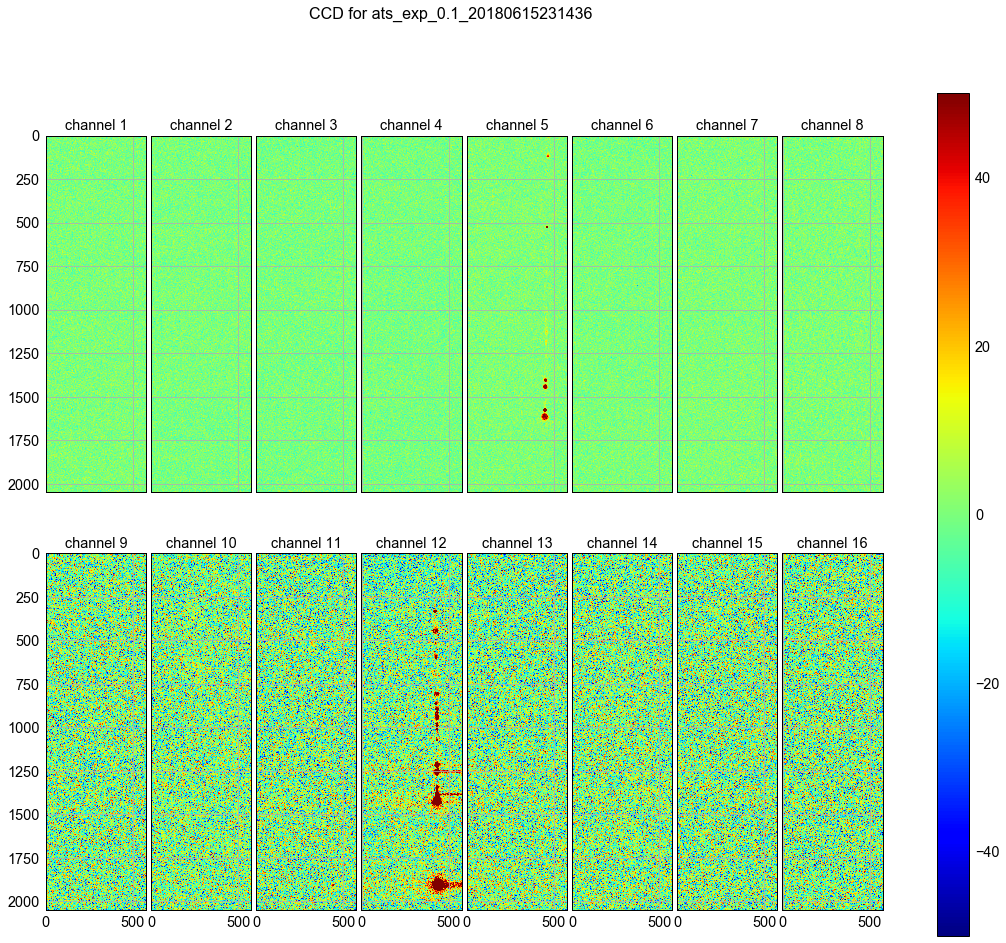

In [26]:
all_images=ShowImagesSet(path,image_file,dark_file)

In [27]:
def ShowHistoSet(path,filename1,filename2):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
    image_file=os.path.join(path,filename1) # make the full filename    
    hdu_list = fits.open(image_file)       # open the file
    
    dark_file=os.path.join(path,filename2) # make the full filename    
    hdu_list_2 = fits.open(dark_file)       # open the file
    
    #hdu_list.info()	 # to know the composition of the files (header+images)		
    header=hdu_list[0].header           # retrieve the header
    #number_of_channels=header['CHAN']   # number of channels in the CCD
    number_of_channels=16
    
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
    #f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
    f.subplots_adjust(hspace=0.5,wspace=0.5)

    for index in range(0,number_of_channels,1):  
        ix=index%4
        iy=index/4
        image_data = hdu_list[index+1].data
        dark_data=hdu_list_2[index+1].data
        
        delta_data=image_data-dark_data
        delta_data=delta_data-np.median(delta_data)
        
        data=delta_data.flatten()
        
        themean=np.mean(data)
        therms=np.std(data)
        label="m = {:2.2f} $\sigma$ = {:2.2f}".format(themean,therms)
        
        axarr[iy,ix].hist(data,bins=100,facecolor='blue', alpha=0.75,log=True,label=label)  # plot the image
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].legend(loc='best')
        axarr[iy,ix].set_ylim(0,1e7)
        #axarr[iy,ix].set_yscale('log')
        
    hdu_list.close()
    plt.yscale('log')
    title='Histogram for {}'.format(object_name)
    plt.suptitle(title,size=16)

/Users/dagoret/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


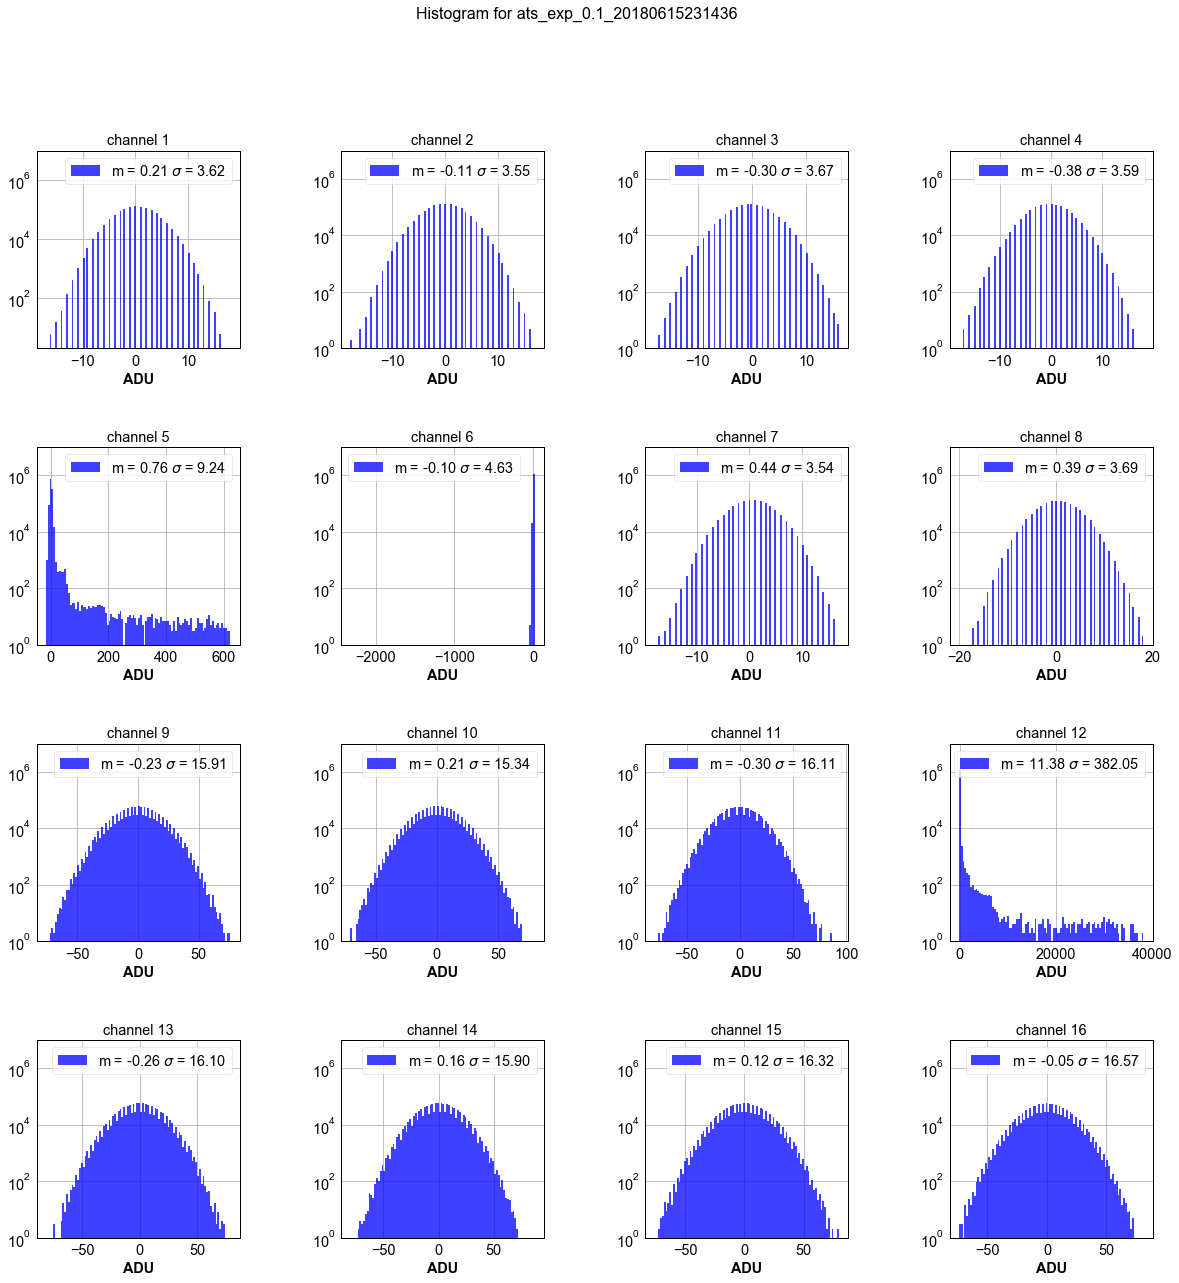

In [28]:
ShowHistoSet(path,image_file,dark_file)

In [29]:
def ShowHistoSumAxis(path,filename1,filename2,ax=0):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
    image_file=os.path.join(path,filename1) # make the full filename    
    hdu_list = fits.open(image_file)       # open the file
    
    dark_file=os.path.join(path,filename2) # make the full filename    
    hdu_list_2 = fits.open(dark_file)       # open the file
    
    
    
    #hdu_list.info()	 # to know the composition of the files (header+images)		
    header=hdu_list[0].header           # retrieve the header
    number_of_channels=16 # number of channels in the CCD
    
    NX=1 # number of images along the horizontal axis
    NY=1 # number of images along the vertical axis
    f, axarr = plt.subplots(NY,NX,figsize=(20,6)) # figure organisation

    for index in range(0,number_of_channels,1):  
        
        image_data = hdu_list[index+1].data
        dark_data=hdu_list_2[index+1].data
        
        delta_data=image_data-dark_data
        
        
        data=np.mean(delta_data,axis=ax)
        min=delta_data.min()
        max=delta_data.max()
        
        plabel='channel {}'.format(index+1)
        plt.plot(np.arange(data.shape[0]),data,label=plabel)  # plot the image
    
    if ax == 0:
        plt.xticks(np.arange(0, data.shape[0]+1, 10.))
        plt.grid(True)
    else:
        plt.xticks(np.arange(0, data.shape[0]+1, 50.))
        plt.grid(True)
    hdu_list.close()
    plt.legend(loc='best')
    title=' axis {} '.format(ax)
    plt.suptitle(title,size=16)
    

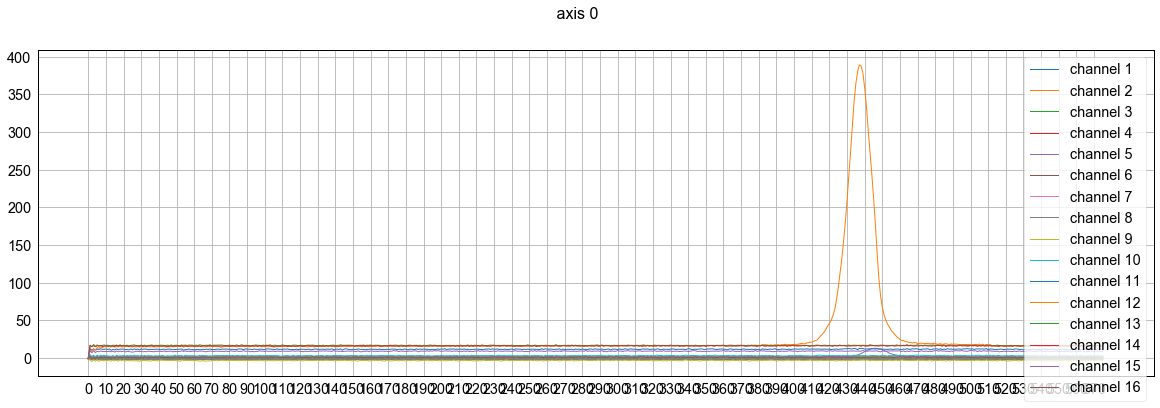

In [30]:
ShowHistoSumAxis(path,image_file,dark_file)

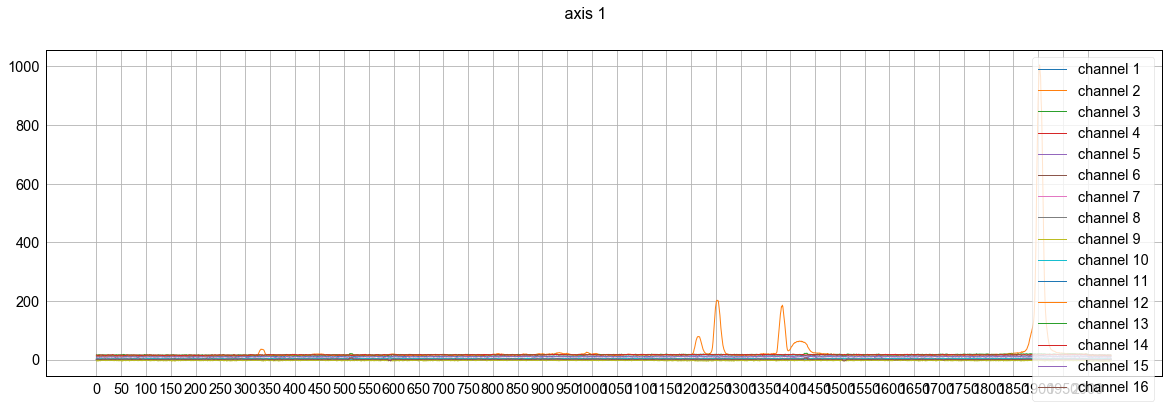

In [31]:
ShowHistoSumAxis(path,image_file,dark_file,ax=1)

In [32]:
#image1=all_images[4]
#image2=all_images[11]

image1=np.copy(all_images[4][:2000,:512])
image2=np.copy(all_images[11][:2000,:512])

In [33]:
image1_flipped=np.flipud(image1)

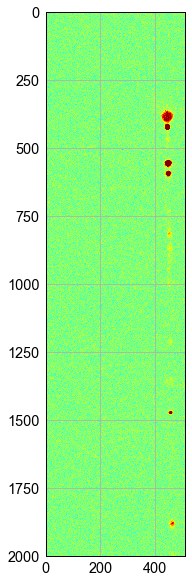

In [34]:
plt.imshow(image1_flipped,cmap='jet',vmin=-50,vmax=50)

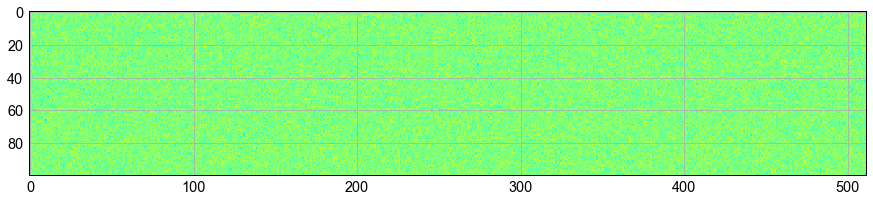

In [35]:
plt.imshow(image1_flipped[0:100,:],cmap='jet',vmin=-50,vmax=50)

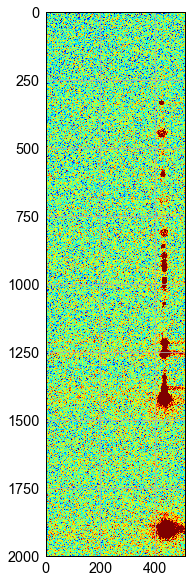

In [36]:
plt.imshow(image2,cmap='jet',vmin=-50,vmax=50)

In [37]:
imageup=image2
imagedo=image1_flipped

In [38]:
full_image = np.concatenate((imageup,imagedo),axis=0).T
full_image_flipped=np.fliplr(full_image)

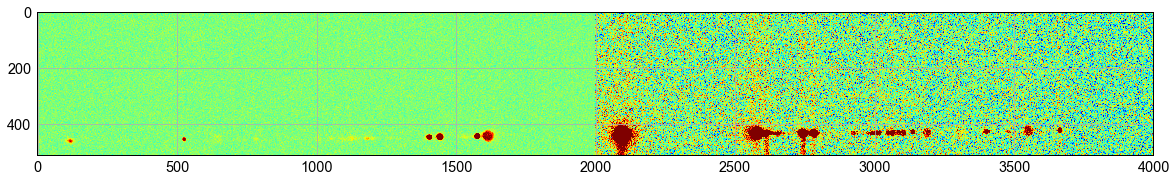

In [39]:
plt.figure(figsize=(20,10))
plt.imshow(full_image_flipped,cmap='jet',vmin=-50,vmax=50)
plt.grid(True)

In [40]:
rotated_image=ndimage.interpolation.rotate(full_image_flipped,-.75)

Text(0,0.5,'pixel Y')

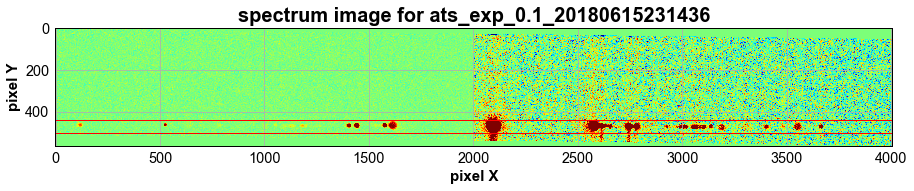

In [41]:
plt.figure(figsize=(15,10))
plt.imshow(rotated_image,cmap='jet',vmin=-50,vmax=50)
plt.plot([0,4000],[440,440],color='red')
plt.plot([0,4000],[500,500],color='red')

#plt.plot([0,4000],[280,280],color='red')
#plt.plot([0,4000],[320,320],color='red')

plt.grid(True)
title="spectrum image for {}".format(object_name)
plt.title(title,fontsize='20',fontweight='bold')
plt.xlabel("pixel X",fontsize='15',fontweight='bold')
plt.ylabel("pixel Y",fontsize='15',fontweight='bold')

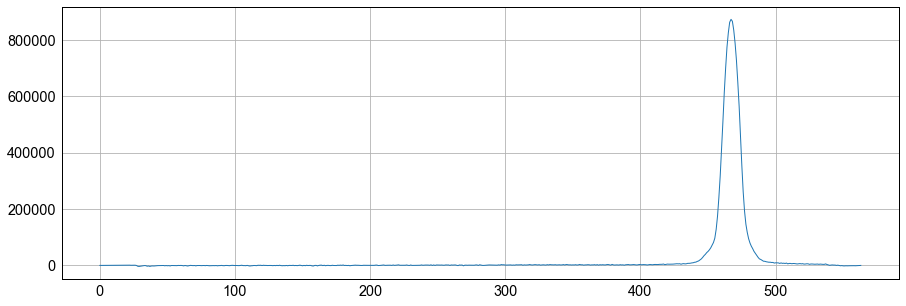

In [42]:
plt.figure(figsize=(15,5))
plt.plot(rotated_image.sum(axis=1))
plt.grid(True)

In [43]:
spectrum_img=full_image_flipped[440:500,:]
#spectrum_img=full_image_flipped[280:320,:]

In [44]:
spectrum=spectrum_img.sum(axis=0)

In [45]:
index_of_maximum=np.where(spectrum==spectrum.max())[0][0]

In [46]:
index_of_maximum

2097

In [47]:
spectrum.shape[0]

4000

Text(0,0.5,'ADU sum')

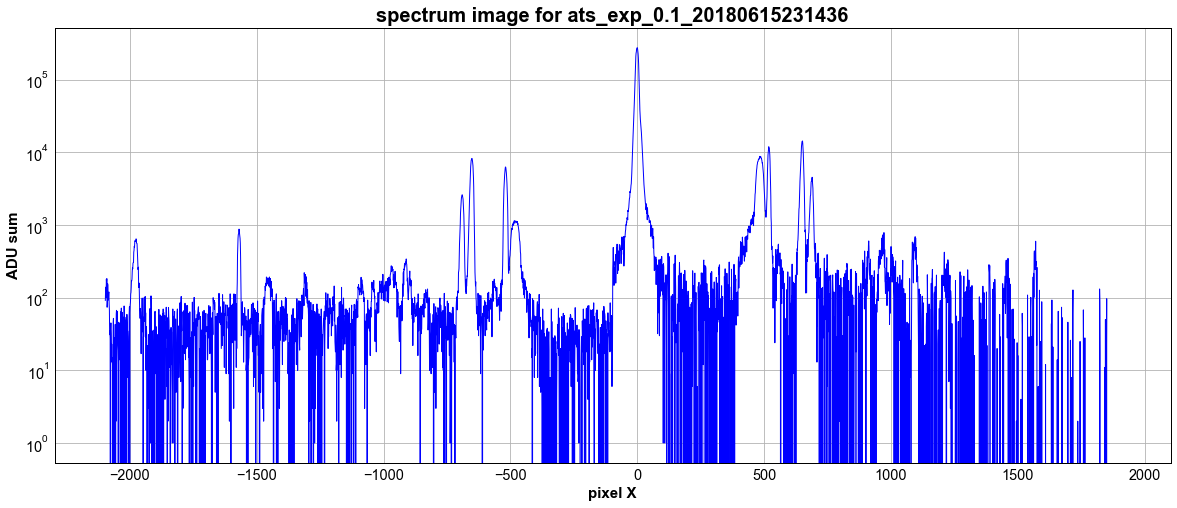

In [48]:
plt.figure(figsize=(20,8))
plt.semilogy(np.arange(spectrum.shape[0])-index_of_maximum,spectrum,'b-')
plt.grid(True)
plt.title(title,fontsize='20',fontweight='bold')
plt.xlabel("pixel X",fontsize='15',fontweight='bold')
plt.ylabel("ADU sum",fontsize='15',fontweight='bold')

(0.0, 10000)

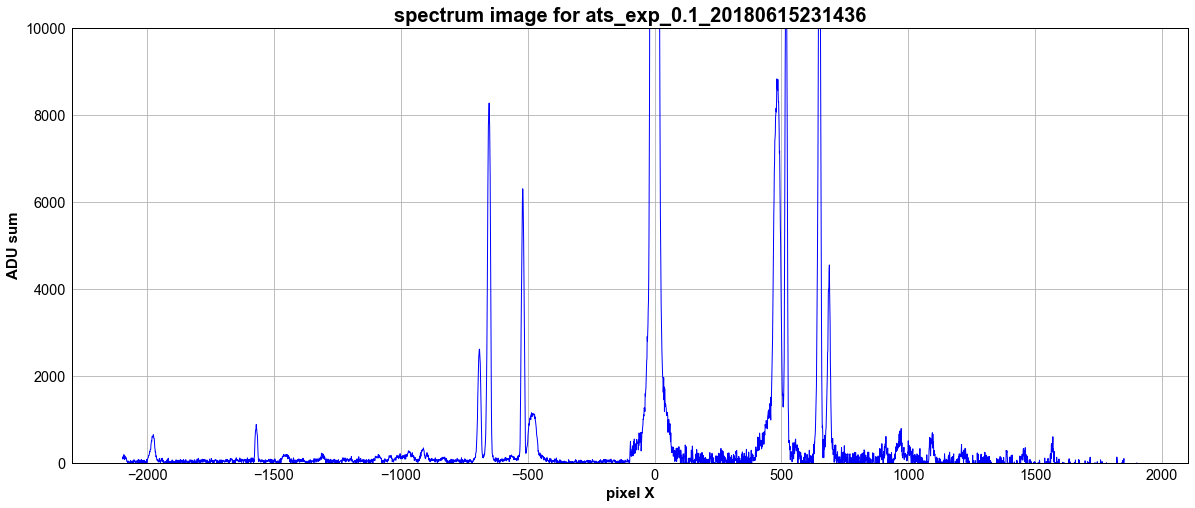

In [49]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(spectrum.shape[0])-index_of_maximum,spectrum,'b-')
plt.grid(True)
plt.title(title,fontsize='20',fontweight='bold')
plt.xlabel("pixel X",fontsize='15',fontweight='bold')
plt.ylabel("ADU sum",fontsize='15',fontweight='bold')
plt.ylim(0.,10000)

In [50]:
# identification by eye
pixel=[-1200.,-970.0,-911.76,-690.62,-651.811,-519.835,-480.63,0.,482.89,518.741,651.33,688.739,912,967,1096.7,1200.]
lambdawl=[-1000.,-811.53,-763.51,-578.013,-546.074,-435.883,-404.656,0.,404.656,435.883,546.074,578.013,763.51,811.53,912.3,1000.]
    

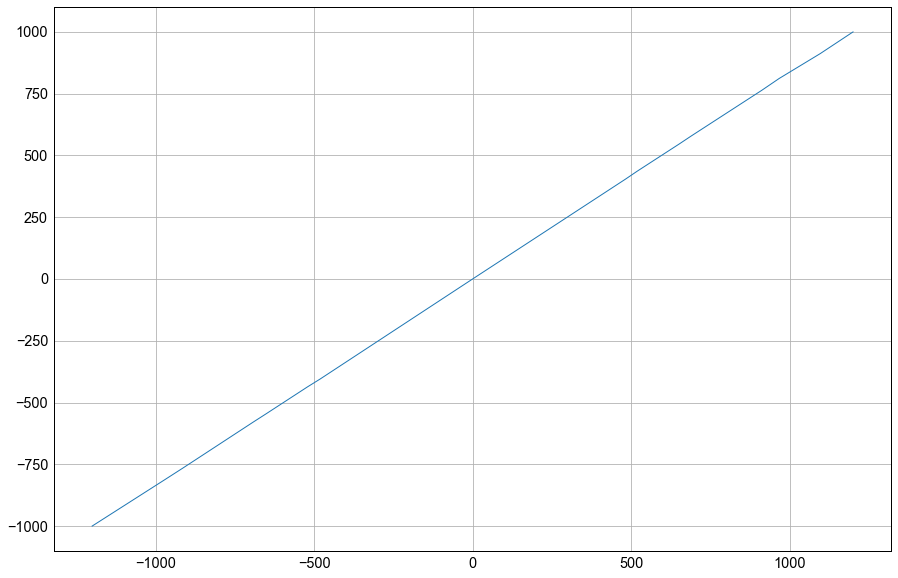

In [51]:
plt.plot(pixel,lambdawl)

In [52]:
x= pixel
y=lambdawl  
z= np.polyfit(x, y, 1)
pol = np.poly1d(z)

In [53]:
all_wl=pol(np.arange(spectrum.shape[0])-index_of_maximum)

Text(0,0.5,'ADU sum')

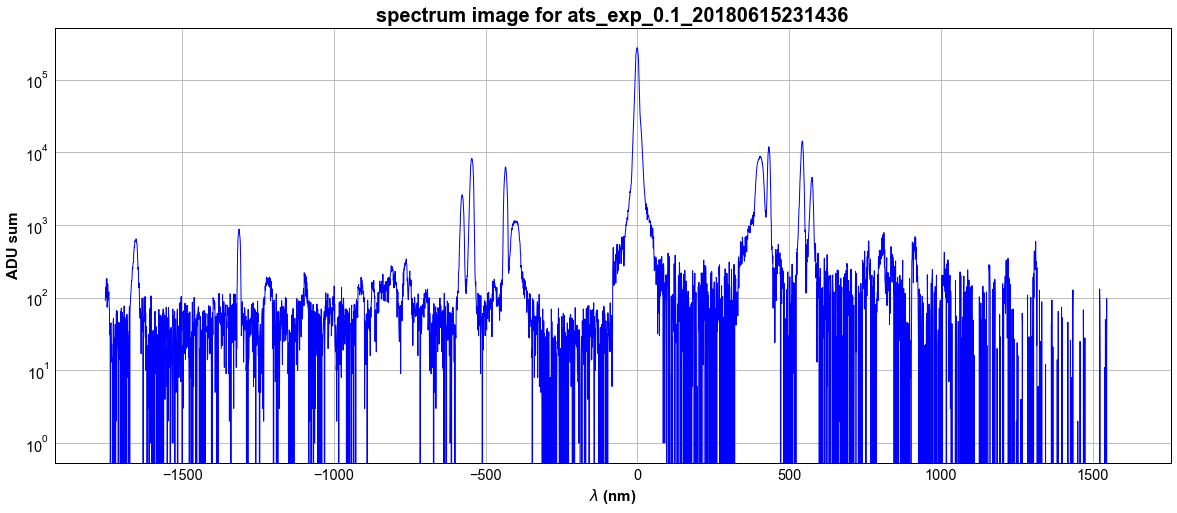

In [54]:
plt.figure(figsize=(20,8))
plt.semilogy(all_wl,spectrum,'b-')
plt.grid(True)
plt.title(title,fontsize='20',fontweight='bold')
plt.xlabel("$\lambda$ (nm)",fontsize='15',fontweight='bold')
plt.title(title,fontsize='20',fontweight='bold')
plt.ylabel("ADU sum",fontsize='15',fontweight='bold')

(0.0, 10000)

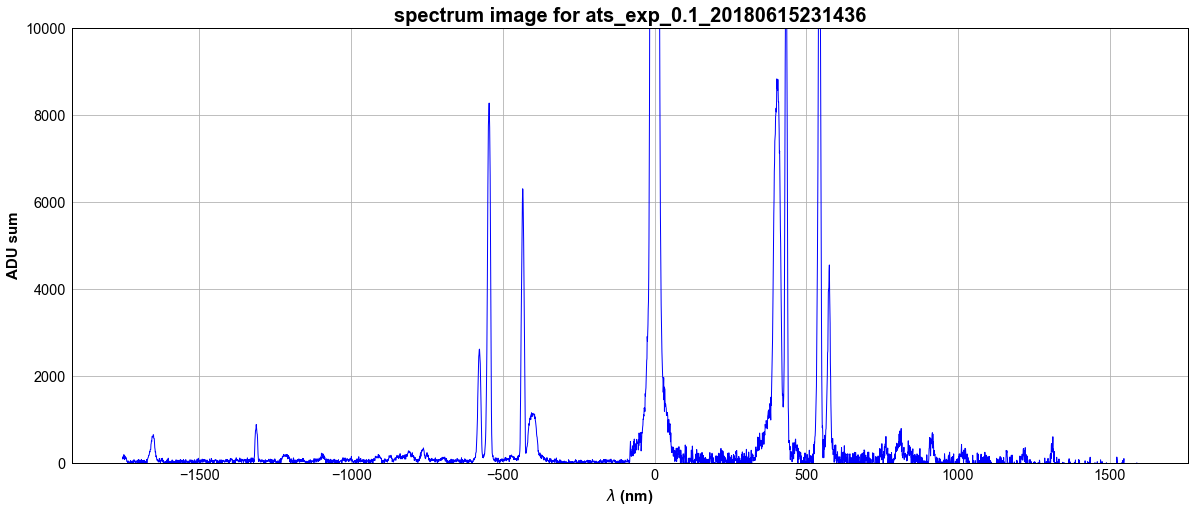

In [55]:
plt.figure(figsize=(20,8))
plt.plot(all_wl,spectrum,'b-')
plt.grid(True)
plt.title(title,fontsize='20',fontweight='bold')
plt.xlabel("$\lambda$ (nm)",fontsize='15',fontweight='bold')
plt.ylabel("ADU sum",fontsize='15',fontweight='bold')
plt.ylim(0.,10000)

In [56]:
np.savetxt(output_file2,np.c_[all_wl,spectrum]) 

In [57]:
!ls *.txt

ats_exp_0.1_20180615231436.txt    ats_exp_0.5_20180615020051.txt
ats_exp_0.1_20180615231436_wl.txt
